In [99]:
import requests
import re
import time
import datetime
import json
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import parser
import random
from collections import Counter
from bs4 import BeautifulSoup
from sklearn import preprocessing
import urllib
import matplotlib.pyplot as plt
import imp
imp.reload(parser)
%matplotlib inline

In [2]:
team_searched = 'PSG Paris'
team = {}
team_searched = urllib.parse.quote(team_searched.encode('utf-8'))
search_link = "http://us.soccerway.com/search/teams/?q={}".format(team_searched)
response = requests.get(search_link)
bs = BeautifulSoup(response.text, 'lxml')
results = bs.find("ul", class_='search-results')
# Take the first results
link = "http://us.soccerway.com" + results.find_all('a')[0]['href']
team['id_'] = results.find_all('a')[0]["href"].split('/')[4]
team['name'] = results.find_all('a')[0].text

## Games

### Parsing

In [67]:
nb_pages = 5
games = []
for page_number in range(nb_pages):
    link_base = 'http://us.soccerway.com/a/block_team_matches?block_id=page_team_1_block_team_matches_3&callback_params=' 
    link_ = urllib.parse.quote('{"page":0,"bookmaker_urls":[],"block_service_id":"team_matches_block_teammatches","team_id":%s,\
    "competition_id":0,"filter":"all","new_design":false}' % team['id_']) + '&action=changePage&params=' + urllib.parse.quote('{"page":-%s}' % (page_number))
    link = link_base + link_
    response = requests.get(link)

    test = json.loads(response.text)['commands'][0]['parameters']['content']
    bs = BeautifulSoup(test, 'lxml')

    for kind in ['even', 'odd']:
        for elem in bs.find_all('tr', class_ = kind):
            game = {}
            game["date"] = elem.find('td', {'class': ["full-date"]}).text
            game["competition"] = elem.find('td', {'class': ["competition"]}).text
            game["team_a"] = elem.find('td', class_='team-a').text
            game["team_b"] = elem.find('td', class_='team-b').text
            game['link'] = "http://us.soccerway.com" + elem.find('td', class_='score-time').find('a')['href']
            game["score"] = elem.find('td', class_='score-time').text.replace(' ','')
            if 'E' in game["score"]:
                game["score"] = game['score'].replace('E','')
                game['extra_time'] = True
            if 'P' in game["score"]:
                game["score"] = game['score'].replace('P','')
                game['penalties'] = True
            if datetime.datetime.strptime(game["date"], '%d/%m/%y') < datetime.datetime.now():
                game = parser.get_score_details(game, team)
                time.sleep(random.uniform(0, 0.25))
                game.update(parser.get_goals(game['link']))
            else:
                del game['score']
            games.append(game)
    games = sorted(games, key=lambda x:datetime.datetime.strptime(x['date'], '%d/%m/%y'))

### Analysis

In [ ]:
def shot_team(row, columns):
    try:
        for col in columns:
            if row['team_a'] == 'PSG':
                row['{}_PSG'.format(col.lower().replace(' ','_'))] = row[col]['team_a'] 
                row['{}_adv'.format(col.lower().replace(' ','_'))] = row[col]['team_b'] 
            else:
                row['{}_PSG'.format(col.lower().replace(' ','_'))] = row[col]['team_b'] 
                row['{}_adv'.format(col.lower().replace(' ','_'))] = row[col]['team_a']
    except:
        pass
    return row

In [148]:
df = pd.DataFrame(games)
df.date = pd.to_datetime(df.date.apply(lambda x:'/'.join([x.split('/')[1],x.split('/')[0], x.split('/')[2]])))
df['month'] = df.date.apply(lambda x:x.month)
df['year'] = df.date.apply(lambda x:x.year)
df = df.sort_values('date', ascending=False)
# le = preprocessing.LabelEncoder()
# df.competition = le.fit_transform(df.competition)
df = df[df.date < datetime.datetime.now()]
df[['competition', 'date', 'result', 'team_a', 'score', 'team_b', 'players_teams_a', 'players_team_b']].head()
cols = ['Corners', 'Fouls', 'Offsides', 'Shots on target', 'Shots wide']
df = df.apply(lambda x:shot_team(x, cols),axis=1)
df = df.drop(cols, axis=1)
df.head()

,competition,corners_PSG,corners_adv,date,extra_time,fouls_PSG,fouls_adv,goals_a,goals_b,link,...,score,shots_on_target_PSG,shots_on_target_adv,shots_wide_PSG,shots_wide_adv,subs_in_a,subs_in_b,team_a,team_b,year
242,LI1,8.0,2.0,2017-04-30,NaN,15.0,11.0,"[{'assist': 'Ricardo Pereira', 'player': 'M. B...","[{'assist': 'Thiago Silva', 'player': 'Marquin...",http://us.soccerway.com/matches/2017/04/30/fra...,...,3-1,5.0,1.0,9.0,3.0,"[A. Donis, M. Le Bihan, M. Obbadi]","[T. Meunier, A. Rabiot, Lucas Moura]",Nice,PSG,2017
241,CDF,13.0,1.0,2017-04-26,NaN,6.0,10.0,"[{'assist': 'E. Cavani', 'player': 'J. Draxler...",[],http://us.soccerway.com/matches/2017/04/26/fra...,...,5-0,8.0,3.0,8.0,1.0,"[Lucas Moura, A. Rabiot, Gonçalo Guedes]","[A. Bongiovanni, K. Dabila]",PSG,Monaco,2017
240,LI1,6.0,6.0,2017-04-22,NaN,9.0,5.0,"[{'assist': 'B. Matuidi', 'player': 'E. Cavani...",[],http://us.soccerway.com/matches/2017/04/22/fra...,...,2-0,7.0,4.0,5.0,7.0,"[J. Draxler, Lucas Moura, G. Lo Celso]","[J. Ikoné, K. Dolly, S. Camara]",PSG,Montpellier,2017
239,LI1,8.0,1.0,2017-04-18,NaN,11.0,12.0,"[{'player': 'Y. Jouffre', 'time': '78'}, {'ass...","[{'assist': 'Maxwell', 'player': 'E. Cavani', ...",http://us.soccerway.com/matches/2017/04/18/fra...,...,2-3,7.0,1.0,5.0,3.0,"[I. Sarr, C. Diabaté, Y. Jouffre]","[J. Pastore, Gonçalo Guedes]",Metz,PSG,2017
238,LI1,1.0,5.0,2017-04-14,NaN,10.0,13.0,[],"[{'player': 'Á. di María', 'time': '28'}, {'as...",http://us.soccerway.com/matches/2017/04/14/fra...,...,0-2,0.0,8.0,7.0,8.0,"[J. Bamba, K. Bérigaud]","[Lucas Moura, T. Motta, Gonçalo Guedes]",Angers SCO,PSG,2017


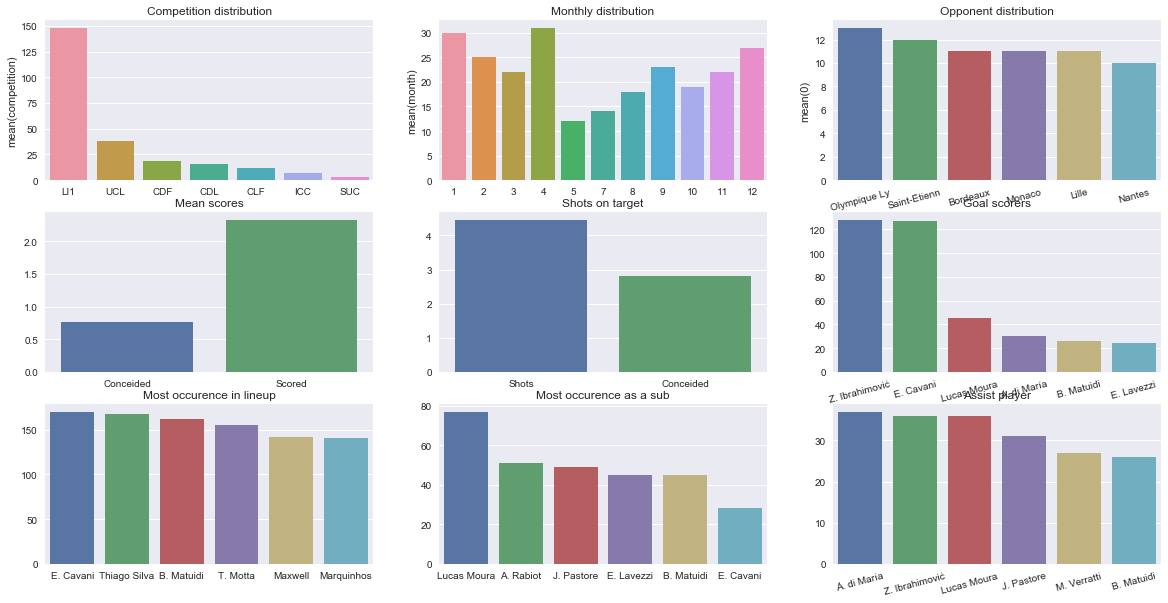

In [193]:
f, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,10))

d = df.competition.value_counts()
sns.barplot(d.index, d, ax=ax[0][0])
ax[0][0].set_title('Competition distribution')

d = {'Scored':df.nb_goals_PSG.mean(), 'Conceided':df.nb_goals_adv.mean()}
sns.barplot(list(d.keys()), list(d.values()) , ax=ax[1][0])
ax[1][0].set_title('Mean scores')

d = sorted(Counter(np.concatenate(list(df.players_teams_a) + list(df.players_team_b))).items(), key=lambda x:x[1], reverse=True)[:6]
sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][0])
ax[2][0].set_title('Most occurence in lineup')

d = df.month.value_counts()
sns.barplot(d.index, d, ax=ax[0][1])
ax[0][1].set_title('Monthly distribution')

d = {'Shots':df.shots_on_target_PSG.mean(), 'Conceided':df.shots_on_target_adv.mean()}
sns.barplot(list(d.keys()), list(d.values()) ,ax=ax[1][1])
ax[1][1].set_title('Shots on target')

d = sorted(Counter(np.concatenate(list(df.subs_in_a) + list(df.subs_in_b))).items(), key=lambda x:x[1], reverse=True)[:6]
sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][1])
ax[2][1].set_title('Most occurence as a sub')

d = pd.DataFrame(pd.concat([df.team_a, df.team_b]))[0].value_counts()[1:7]
plot = sns.barplot(d.index, d, ax=ax[0][2])
_ = plot.set_xticklabels([elem[:12] for elem in d.index], rotation=15)
ax[0][2].set_title('Opponent distribution')

d = sorted(Counter([elem['player'] for elem in np.concatenate(list(df.goals_a) + list(df.goals_b))]).items(), key=lambda x:x[1], reverse=True)[:6]
plot = sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[1][2])
_ = plot.set_xticklabels([elem[0] for elem in d], rotation=15)
ax[1][2].set_title('Goal scorers')

d = sorted(Counter([elem['assist'] for elem in np.concatenate(list(df.goals_a) + list(df.goals_b)) if 'assist' in elem]).items(), key=lambda x:x[1], reverse=True)[:6]
plot = sns.barplot([elem[0] for elem in d], [elem[1] for elem in d], ax=ax[2][2])
_ = plot.set_xticklabels([elem[0] for elem in d], rotation=15)
ax[2][2].set_title('Assist player')